# Cape Town Air BNB Prices #

## 1. Import Libraries and Read in Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')  

import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
import sklearn.metrics
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
from geopy.distance import great_circle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot


/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import warnings

In [3]:
# Read in data 

listing_df = pd.read_csv('listings.csv')

In [4]:
# Read in crime statistics data to compliment neighbourhoods

crime_df = pd.read_csv('SA_crime_ward.csv')

In [5]:
#drop the nan row (was originally a double of column names not values)

crime_df.drop(111, inplace = True)

## 2. Clean the data. 

In [6]:
# Dealing with NAs starting with Listing DataFrame
listing_df.isna().sum()

id                                    0
name                                  0
host_id                               0
host_name                             3
neighbourhood_group               24079
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        6823
reviews_per_month                  6823
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
# Because the data set is over 24k, I decided to drop the nan values of reviews and last review (the same rows were nan for each)
# In researching SA Cape Town Air BNB, I found that houses with no reviews tended to have been expensive, but never booked
# Dropping these values, I expect to increase accuracy as some houses with massive price tags have never been booked or reviewed

listing_df['number_of_reviews'] = listing_df['number_of_reviews'].replace(np.nan, 0)

In [8]:
listing_df['last_review'] = listing_df['last_review'].replace(np.nan, 0)

In [9]:
listing_df['reviews_per_month'] = listing_df['reviews_per_month'].replace(np.nan, 0)

In [10]:
# No values in this column at all, drop column

listing_df = listing_df[listing_df.columns.drop('neighbourhood_group')]

In [11]:
# Seemingly half of the rates were in ZAR and half in dollars (lower cost was in USD)
# Air BNB zar conversion rate is 14.3 (current rate is 16.5)
# The most expensive house I could find was 3,000 that had been reviewed once/had been booked

listing_df['price_usd'] = listing_df.price.apply(lambda x: x/14.23 if x>= 3000 else x)

In [12]:
# Testing for listings with price = 0
# Closed listing does not exist 9775 is 20685098 and it is listed as price = 0 


In [13]:
listing_df.drop(9775, inplace = True)

In [14]:
#listing append 9808 is 20736711 price was 0.0 is actually 121 USD, minimum night 7

listing_df.at[9808, 'price_usd'] = 121
listing_df.at[9808, 'minimum_nights'] = 7

In [15]:
#minimum nights is 1125, which while this is true on airbnb, this place has not been booked at this minimum night and I believe it would scew the data. 

listing_df.drop(4957, inplace = True)

In [16]:
# drop the outlier for minimum_nights at 1125
listing_df[listing_df['minimum_nights'] == 1125]
listing_df.drop(4598, inplace = True)

In [17]:
# Limit outliers of price from both low end (under $20) and high end (above $2500)
listing_df = listing_df[listing_df["price"]<2500].copy()
listing_df = listing_df[listing_df["price"]>20].copy()

In [18]:
listing_df['price'].describe()

count    18989.000000
mean      1005.672073
std        538.393051
min        119.000000
25%        592.000000
50%        898.000000
75%       1341.000000
max       2495.000000
Name: price, dtype: float64

In [19]:
# Splitting by room type by making dummy binomial variables

listing_df = pd.get_dummies(listing_df, columns=['room_type'])

In [20]:
# Neighbourhoods

listing_df.neighbourhood = listing_df.neighbourhood.map(lambda x: x.replace('Ward', ''))

In [21]:
listing_df.neighbourhood = listing_df.neighbourhood.astype(int)

In [22]:
crime_df['geo_code'].astype(int)

0        1
1        2
2        3
3        4
4        5
      ... 
106    107
107    108
108    109
109    110
110    111
Name: geo_code, Length: 111, dtype: int64

In [23]:
# Merge df on geo code/neighbourhood for the crime stats to get the total crime per 10,000 tied to each listing
# My thought process was that there may be a significant difference in price between somewhere with higher crime and lower crime rates


listing_df = listing_df.merge(crime_df, left_on='neighbourhood', right_on = 'geo_code' ,how='left').copy()


In [24]:
listing_df.head()


,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_usd,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,geo_level,geo_code,0_14,15_24,25_34,35_44,45_54,55_64,65+,total_raw,total_10000 _rounded
0,3191,Malleson Garden Cottage,3754,Brigitte,57,-33.94739,18.47600,819,3,54,2020-03-07,0.63,1,362,819.0,1,0,0,0,ward,57.0,24.0,219.0,456.0,432.0,303.0,141.0,120.0,1695.0,242.0
1,15007,Blaauwberg House,59072,Dirk,23,-33.80001,18.46063,2050,2,27,2019-08-18,0.34,4,251,2050.0,1,0,0,0,ward,23.0,39.0,270.0,357.0,210.0,153.0,42.0,30.0,1101.0,157.0
2,15077,Top relaxed beach living in style,59342,Georg,4,-33.85812,18.49043,1620,5,5,2016-12-10,0.06,5,208,1620.0,0,0,1,0,ward,4.0,39.0,306.0,447.0,309.0,180.0,132.0,90.0,1503.0,215.0
3,15180,The Melkbaai - Beachfront,59663,Heinri,83,-34.11124,18.82349,575,2,0,0,0.00,1,365,575.0,1,0,0,0,ward,83.0,66.0,549.0,579.0,396.0,273.0,114.0,57.0,2034.0,291.0
4,15285,Waterford-Guinea Fowl Self Catering,59964,Chris+Alison,71,-34.03863,18.43128,1202,2,8,2019-12-30,0.08,3,303,1202.0,1,0,0,0,ward,71.0,39.0,273.0,405.0,246.0,132.0,126.0,18.0,1239.0,177.0


In [25]:
#Limit air bnb to those where minimum stay is 14 days or less
listing_df = listing_df[listing_df["minimum_nights"] < 15]

 Drop rows not needed for calculations/clean up remaining DataFrame: 

In [26]:
listing_df = listing_df[listing_df.columns.drop('0_14')]

In [27]:
listing_df = listing_df[listing_df.columns.drop('15_24')]

In [28]:
listing_df = listing_df[listing_df.columns.drop('25_34')]

In [29]:
listing_df = listing_df[listing_df.columns.drop('35_44')]

In [30]:
listing_df = listing_df[listing_df.columns.drop('45_54')]

In [31]:
listing_df = listing_df[listing_df.columns.drop('55_64')]

In [32]:
listing_df = listing_df[listing_df.columns.drop('65+')]

In [33]:
listing_df = listing_df[listing_df.columns.drop('total_raw')]

In [34]:
listing_df = listing_df[listing_df.columns.drop('geo_level')]

In [35]:
listing_df = listing_df[listing_df.columns.drop('host_name')]

In [36]:
listing_df = listing_df[listing_df.columns.drop('name')]

In [37]:
listing_df = listing_df[listing_df.columns.drop('host_id')]

In [38]:
listing_df = listing_df[listing_df.columns.drop('last_review')]

In [39]:
listing_df = listing_df[listing_df.columns.drop('calculated_host_listings_count')]

In [40]:
listing_df = listing_df[listing_df.columns.drop('geo_code')]

In [41]:
print('Final Columns', listing_df.columns)

Final Columns Index(['id', 'neighbourhood', 'latitude', 'longitude', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'availability_365', 'price_usd', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'total_10000 _rounded'],
      dtype='object')


## 3. Feature Engineering 

In [42]:
# Ward 112 impute mean crime from surounding wards (Ward 103, Ward 21, Ward 70 = 175)

In [43]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 112), 175, listing_df['total_10000 _rounded'])

In [44]:
# Ward 113  impute mean crime from surounding wards (Ward 107, Ward 1, Ward 4 = 237)

In [45]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 113), 237, listing_df['total_10000 _rounded'])

In [46]:
# Ward 114  impute mean crime from surounding wards (Ward 108, Ward 16, Ward 20. Ward 18 = 288)

In [47]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 114), 288, listing_df['total_10000 _rounded'])

In [48]:
# Ward 115  impute mean crime from surounding wards (Ward 54, Ward 57, Ward 77, Ward 55 = 266)

In [49]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 115), 266, listing_df['total_10000 _rounded'])

In [50]:
# Ward 116  impute mean crime from surounding wards (Ward 87, Ward 18, Ward 35, Ward 76, Ward 92, Ward 79, Ward 78 = 265)

In [51]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 116), 265, listing_df['total_10000 _rounded'])

 Created the log of Price in USD.
 As you can see, the plot before is less normalized than the log of the price. 

In [52]:
listing_df['price_usd_log'] = np.log(listing_df['price_usd'])

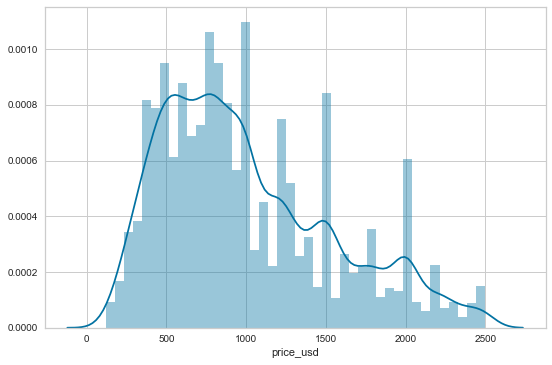

In [53]:
sns.distplot(listing_df['price_usd']);

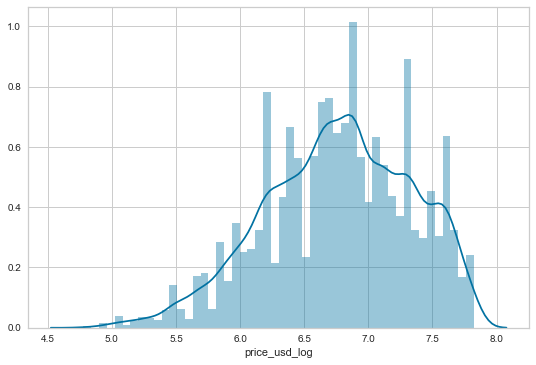

In [54]:
# Using the log I can normalize the plot a little bit 

sns.distplot(listing_df['price_usd_log']);

 Calculated distance from main attractions in Capetown: 

In [55]:
# Distance to Cape Town City Center

city_center = (-33.9249,18.4241)
listing_df['distance_cc'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(city_center, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)
# Distance VA Waterfront 

va_water = (-33.9036, 18.4205)
listing_df['distance_waterfront'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(va_water, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)

# Stellenbosch 

wine_lands = (-34.075691, 18.843266)
listing_df['distance_wine'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(wine_lands, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)

# Distance from Airport

airport = (-33.9249,18.4241)
listing_df['distance_airport'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(airport, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)


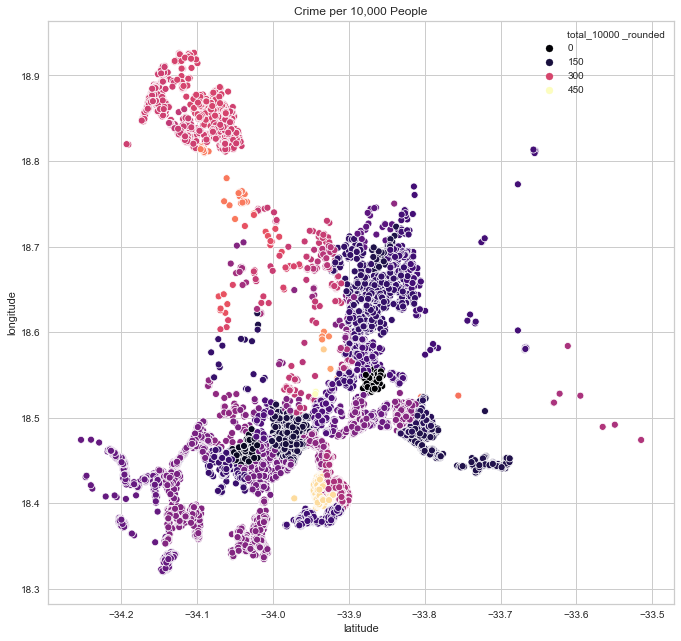

In [56]:
figure,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = listing_df['latitude'],y = listing_df['longitude'],hue = listing_df['total_10000 _rounded'], data = listing_df, palette = 'magma')
plt.title('Crime per 10,000 People');

## 4. Statistical Testing and Visuals


## Two Sample T Test

Question: is minimum nights under or over 4 statistically significant to the price? 

H0: The means of the price are NOT significantly different between those with less than 4 minimum nights and those with more than or equal to 4 minimum nights. 
 


H1:The means of the price ARE significantly different between those with less than 4 minimum nights and those with more than or equal to 4 minimum nights. 

Results: 
alpha 0.05
statistic=22.18163635166698, pvalue=1.3315069062450914e-107
pvalue < alpha

Reject the null hypothesis, there may be some significance to the price difference of means when being above or below 4 nights minimum stay.

In [57]:
# minimum nights > 4
# min nights < 4 
# mean min_nights is 3.93


stats.ttest_ind(listing_df[listing_df['minimum_nights'] >= 4]['price_usd'], listing_df[listing_df['minimum_nights'] < 4]['price_usd']) 


Ttest_indResult(statistic=22.18163635166698, pvalue=1.3315069062450914e-107)

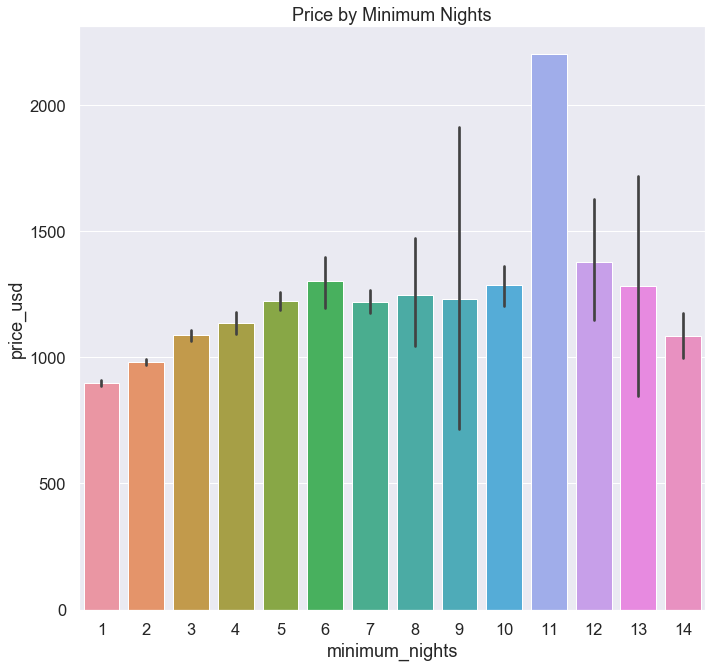

In [58]:

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=1.5)
sns.barplot(x = 'minimum_nights', y = 'price_usd', data = listing_df);
plt.title('Price by Minimum Nights');

## ANOVA Test

Question: Is the closeness to the city center a factor in pricing? 

H0 Closeness to the City Center does NOT have a significant effect on the price_usd. 
 
 

H1 Closeness to the City Center DOES have a significant effect on the price_usd.

In [59]:
# As we get closer the the City Center, the mean of the price changes. 



x = listing_df[listing_df['distance_cc'] >= 10]['price_usd']
y = listing_df[(listing_df['distance_cc'] > 5) & (listing_df['distance_cc'] < 10 )]['price_usd']
z = listing_df[(listing_df['distance_cc'] >= 1) & (listing_df['distance_cc'] < 5)]['price_usd']
miles = stats.f_oneway(x, y, z)
miles


F_onewayResult(statistic=27.290684764278303, pvalue=1.4735626699908444e-12)

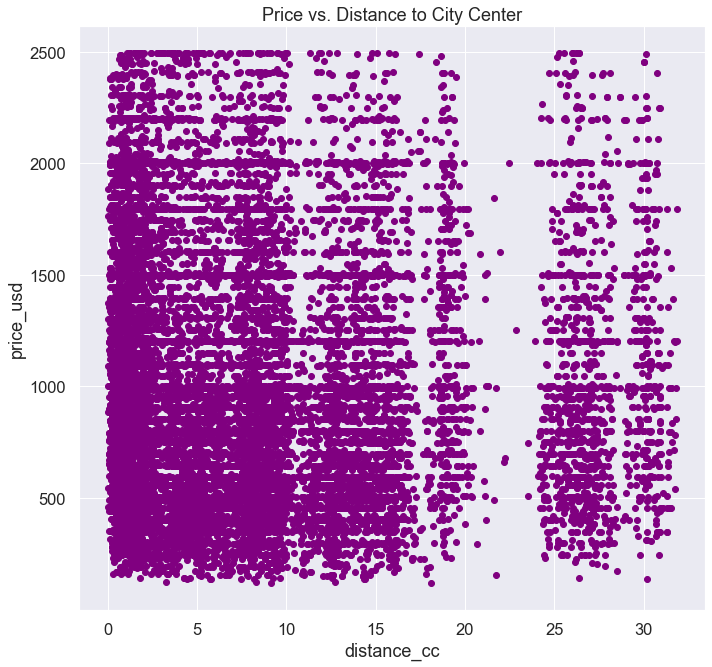

In [60]:
plt.scatter(listing_df['distance_cc'], listing_df['price_usd'], color = 'purple')
plt.xlabel('distance_cc')
plt.ylabel('price_usd')
plt.title('Price vs. Distance to City Center');

## Two Sample T Test 

Question: Is there a significant difference in price if you are less than a mile from city center or greater? 

H0 The distance of under a mile from the city center has NO significant effect on the mean price in USD.



H1 The distance of under a mile from the city center HAS a significant effect on the mean price in USD.

pvalue=0.00021980744429207292 is less than alpha, so we reject the null Hypothesis. 

In [61]:
ttest_distance_cc = stats.ttest_ind(listing_df[listing_df['distance_cc'] < 1]['price_usd'], listing_df[listing_df['distance_cc'] >=1]['price_usd']) 
ttest_distance_cc

Ttest_indResult(statistic=3.5232622354407273, pvalue=0.00042730437619246714)

## Two Sample T Test

H0 Price of an Airbnb in Cape Town is not statistically contingent on the level of crime per 10,000.

H1 Price of an Airbnb in Cape Town is statistically contingent based on the level of crime per 10,000.

 
pvalue=0.00010061964947170236 is less than the alpha 0.05
We can reject the null hypothesis. 

In [62]:
stats.ttest_ind(listing_df[listing_df['total_10000 _rounded'] >= 235.17]['price_usd'], listing_df[listing_df['total_10000 _rounded'] <235.17]['price_usd'])

Ttest_indResult(statistic=-3.983835553088601, pvalue=6.807323565755748e-05)

In [63]:
# When price_usd_log is used, there is some statistical significance 

stats.ttest_ind(listing_df[listing_df['total_10000 _rounded'] >= 235.17]['price_usd_log'], listing_df[listing_df['total_10000 _rounded'] <235.17]['price_usd_log'])

Ttest_indResult(statistic=-3.0009114753277446, pvalue=0.002695340373233734)

### This graphic is interesting as it shows that the air bnbs only have small pockets where the crime rate is over 250-300 per 10,000 
### This may be why there is not enough data to go on, as places with high crime seem to have a very low amount of air bnb housing

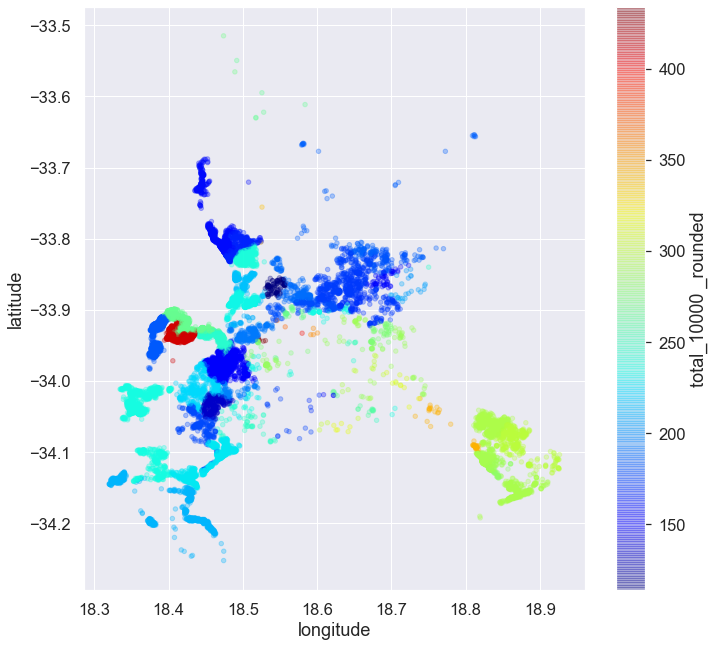

In [64]:
listing_df.plot(kind= 'scatter', x = 'longitude', y = 'latitude', alpha = .3, c = 'total_10000 _rounded', cmap = plt.get_cmap('jet'));


### From this visualization we can see that it looks like the more expensive places are along the coast line if referenced with a map of Cape Town
### The middle area with scarce Airbnb options also seems to correspond to the above chart where the middle portion, the Cape Flats, is higher in crime, and has less Airbnb's in the area, and less expensive ones compared to the coastline. 

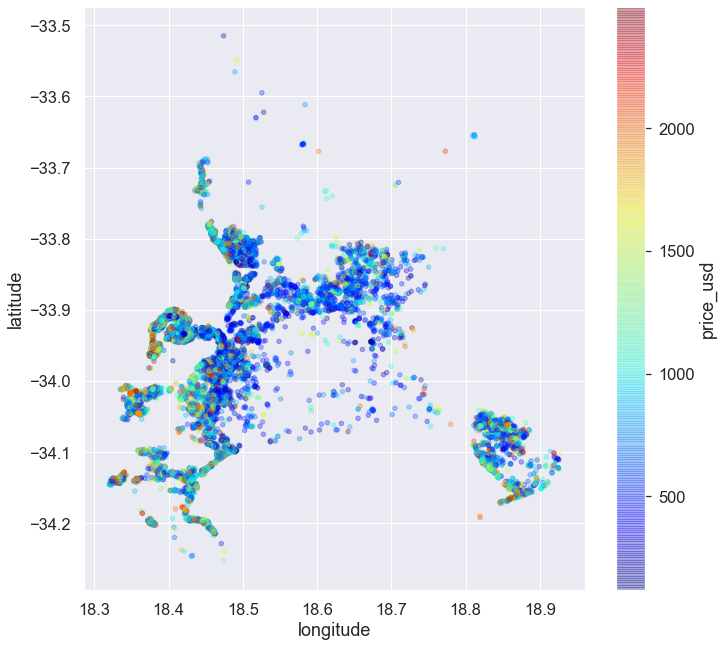

In [65]:
listing_df.plot(kind= 'scatter', x = 'longitude', y = 'latitude', alpha = .3, c = 'price_usd', cmap = plt.get_cmap('jet'));


## ANOVA

Question: Is there a statistically relevant difference in price given the number of reviews?

H0: There is no statistical difference in price based on the number of reviews. 


H1: There is statistical difference in price based on the number of reviews. 

pvalue=1.3652077063392876e-10 based on the p-value being less than alpha, we can reject the null hypothesis and show there is statistical importance in the number of reviews on price. 

In [66]:

x = listing_df[listing_df['number_of_reviews'] >= 100]['price_usd']
y = listing_df[(listing_df['number_of_reviews'] > 20) & (listing_df['number_of_reviews'] < 50 )]['price_usd']
z = listing_df[(listing_df['number_of_reviews'] >= 1) & (listing_df['number_of_reviews'] < 20)]['price_usd']
reviews = stats.f_oneway(x, y, z)
reviews


F_onewayResult(statistic=22.756454535065288, pvalue=1.3652077063392876e-10)

## CHI SQUARED

Because I really only have one catergorical data in the form of what kinds of room, I decided to use minimum nights as catergorical as it can only be 1-15. 
I did not expect to see a significance between them. 

H0 There is no significance between minimum nights and Entire home/apt


H1 There is significance between minimum nights and Entire home/apt

The data seems to be there there is significance between the two. 

In [67]:

contingency_table=pd.crosstab(listing_df["minimum_nights"],listing_df["room_type_Entire home/apt"])
print('contingency_table :-\n',contingency_table)

#Observed Values
Observed_Values = contingency_table.values 
print("Observed Values :-\n",Observed_Values)
b=stats.chi2_contingency(contingency_table)
Expected_Values = b[3]
print("Expected Values :-\n",Expected_Values)
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",ddof)
alpha = 0.05
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)

#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)
if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables, chi_sq_statistic")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")
    
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables, p_value")

contingency_table :-
 room_type_Entire home/apt     0     1
minimum_nights                       
1                          2915  3176
2                          1523  5105
3                           457  2232
4                           112   613
5                           127   785
6                            20   129
7                           121   623
8                             3    25
9                             0     5
10                           23   176
11                            0     1
12                            0    19
13                            1     5
14                           23   158
Observed Values :-
 [[2915 3176]
 [1523 5105]
 [ 457 2232]
 [ 112  613]
 [ 127  785]
 [  20  129]
 [ 121  623]
 [   3   25]
 [   0    5]
 [  23  176]
 [   0    1]
 [   0   19]
 [   1    5]
 [  23  158]]
Expected Values :-
 [[1.76495483e+03 4.32604517e+03]
 [1.92055831e+03 4.70744169e+03]
 [7.79176416e+02 1.90982358e+03]
 [2.10079175e+02 5.14920825e+02]
 [2.64265114e+0

## 5. Baseline model

In [75]:
# Baseline model; rmse:   548.7970187273733 r2:  -0.04000143686100621
subset2 = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
x = listing_df[subset2]
y = listing_df['price_usd']

dummy_regr = DummyRegressor(strategy = "median")
dummy_regr.fit(x, y)
#DummyRegressor()
y_predict = dummy_regr.predict(x)
R2 = dummy_regr.score(x, y)

rmse = np.sqrt(metrics.mean_squared_error(y, y_predict))

print('rmse: ', rmse, 'r2: ', R2)

rmse:  548.7970187273733 r2:  -0.04000143686100621


## 6. Test for Multi-Colinearity  

In [70]:
features = ['minimum_nights','number_of_reviews', 'neighbourhood', 'availability_365', 'room_type_Entire home/apt',
            'room_type_Shared room', 'distance_cc', 'distance_airport', 'distance_wine', 'total_10000 _rounded']


df_features = listing_df[features]
target = listing_df['price_usd_log']
len(features)

10

### I checked for collinearity using this method. Here is one example of how I went through and notated conflicts depending on the column. 

In [71]:
def high_correlation(df):
   
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['v1', 'v2', 'c']
    return corr_df, corr_df[(corr_df.c > 0.8) & (corr_df.c < 1)].sort_values(
        by = 'c', ascending = False)

high_correlation(df_features)

(                      v1                         v2         c
 0         minimum_nights             minimum_nights  1.000000
 1         minimum_nights          number_of_reviews  0.063969
 2         minimum_nights              neighbourhood  0.007853
 3         minimum_nights           availability_365  0.121806
 4         minimum_nights  room_type_Entire home/apt  0.195854
 ..                   ...                        ...       ...
 95  total_10000 _rounded      room_type_Shared room  0.003856
 96  total_10000 _rounded                distance_cc  0.081097
 97  total_10000 _rounded           distance_airport  0.081097
 98  total_10000 _rounded              distance_wine  0.150656
 99  total_10000 _rounded       total_10000 _rounded  1.000000
 
 [100 rows x 3 columns],
 Empty DataFrame
 Columns: [v1, v2, c]
 Index: [])

## 7. Model Testing

## Poly 3 Model

In [72]:
from sklearn.preprocessing import PolynomialFeatures

poly_3 = PolynomialFeatures(degree=3, include_bias = False)
poly3_data = poly_3.fit_transform(df_features)
poly3_columns = poly_3.get_feature_names(df_features.columns)
df_poly3 = pd.DataFrame(poly3_data, columns = poly3_columns)
model3 = LinearRegression()

model3 = model3.fit(df_poly3, target)
model3 = sm.OLS(y, poly3_data).fit()
model3.summary()

/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          price_usd_log   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.936e+04
Date:                Fri, 31 Jul 2020   Prob (F-statistic):                        0.00
Time:                        00:39:19   Log-Likelihood:                         -12387.
No. Observations:               18377   AIC:                                  2.516e+04
Df Residuals:                   18186   BIC:                                  2.665e+04
Df Model:                         191                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4239      0.180      2.360      0.018       0.072       0.776
x2            -0.0543      0.015     -3.694      0.000      -0.083      -0.026
x3            -0.0423      0.017     -2.564      0.010      -0.075      -0.010
x4             0.0030      0.002      1.256      0.209      -0.002       0.008
x5            -0.3634      0.236     -1.541      0.123      -0.826       0.099
x6             2.2903      1.204      1.903      0.057      -0.069       4.650
x7             0.0923      0.042      2.175      0.030       0.009       0.175
x8             0.0923      0.042      2.175      0.030       0.009       0.175
x9             0.5548      0.073      7.584      0.000       0.411       0.698
x10           -0.0042      0.009     -0.482      0.630      -0.021       0.013
x11            0.0037      0.005      0.789      0.430      -0.005       0.013
x12            0.0027      0.001      2.368      0.018       0.000       0.005
x13           -0.0018      0.001     -1.426      0.154      -0.004       0.001
x14           -0.0003      0.000     -1.992      0.046      -0.001   -4.18e-06
x15            0.1096      0.024      4.523      0.000       0.062       0.157
x16            0.1675      0.287      0.585      0.559      -0.394       0.729
x17           -0.0070      0.003     -2.185      0.029      -0.013      -0.001
x18           -0.0070      0.003     -2.185      0.029      -0.013      -0.001
x19           -0.0236      0.009     -2.608      0.009      -0.041      -0.006
x20           -0.0008      0.001     -1.362      0.173      -0.002       0.000
x21            0.0001   1.79e-05      7.066      0.000    9.14e-05       0.000
x22            0.0001      0.000      0.825      0.409      -0.000       0.000
x23        -8.158e-06   1.16e-05     -0.703      0.482   -3.09e-05    1.46e-05
x24           -0.0019      0.002     -1.122      0.262      -0.005       0.001
x25            0.1583      0.119      1.334      0.182      -0.074       0.391
x26            0.0004      0.000      1.318      0.188      -0.000       0.001
x27            0.0004      0.000      1.317      0.188      -0.000       0.001
x28            0.0019      0.001      2.467      0.014       0.000       0.003
x29         6.738e-05   4.96e-05      1.360      0.174   -2.98e-05       0.000
x30            0.0005   8.98e-05      6.018      0.000       0.000       0.001
x31        -6.986e-06   1.55e-05     -0.449      0.653   -3.75e-05    2.35e-05
x32           -0.0005      0.002     -0.224      0.823      -0.005       0.004
x33           -0.0433      0.016     -2.704      0.007      -0.075      -0.012
x34         -6.25e-05      0.000     -0.170      0.865      -0.001       0.001
x35         -6.24e-05      0.000     -0.170      0.865      -

In [102]:
mse = sklearn.metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))
rmse = np.sqrt(mse)
rmse

519.8636117866749

## Lasso Model

In [74]:
y = listing_df['price_usd_log']
x = df_features

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y,random_state = 42, test_size=0.2)

In [76]:
scaler = StandardScaler()

In [77]:
df_features_columns = df_features.columns

In [78]:
catergorical_data = []

In [79]:
continuous_data = []

In [80]:
for i in df_features_columns: 
    if x[i].max == 1:
        catergorical_data.append(i)
    else:
        continuous_data.append(i)

In [81]:
X_train[continuous_data] = scaler.fit_transform(X_train[continuous_data])

/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [82]:
lasso_CV = LassoCV(cv = 5, random_state = 42, verbose = 1)
lasso_CV.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=1)

In [83]:
y_train_lasso_CV_pred = lasso_CV.predict(X_train)

In [84]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(y_train_lasso_CV_pred))))

RMSE:  515.0013547581824


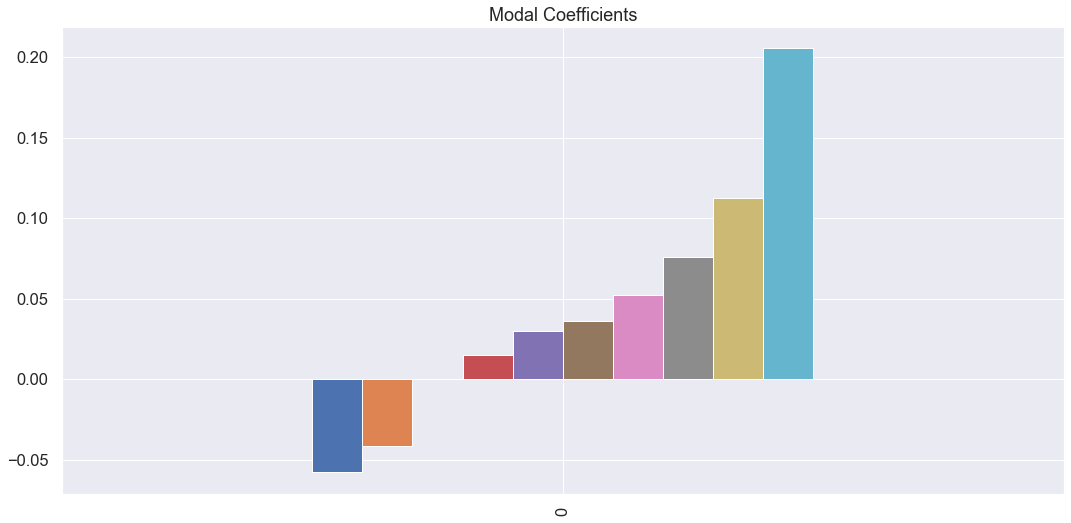

In [85]:
lasso_coef01 = pd.DataFrame(data=lasso_CV.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))



## Poly 3 Model through Lasso Model

In [86]:
y = listing_df['price_usd_log']
x = df_poly3

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df_poly3, y,random_state = 42, test_size=0.2)

In [88]:
df_poly3_columns = df_poly3.columns

In [89]:
scaler = StandardScaler()

In [90]:
X_train[continuous_data] = scaler.fit_transform(X_train[continuous_data])

/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [91]:
catergorical_data = []

In [92]:
continuous_data = []

In [93]:
for i in df_poly3_columns: 
    if x[i].max == 1:
        catergorical_data.append(i)
    else:
        continuous_data.append(i)

In [94]:
lasso_CV = LassoCV(cv = 5, random_state = 42, verbose = 1)
lasso_CV.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................../Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44597345085685447, tolerance: 0.3844951262479193
  tol, rng, random, positive)
...../Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6886788953397627, tolerance: 0.3844951262479193
  tol, rng, random, positive)
./Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=1)

In [95]:
y_train_lasso_CV_pred = lasso_CV.predict(X_train)

In [96]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(y_train_lasso_CV_pred))))

RMSE:  518.5546707977804


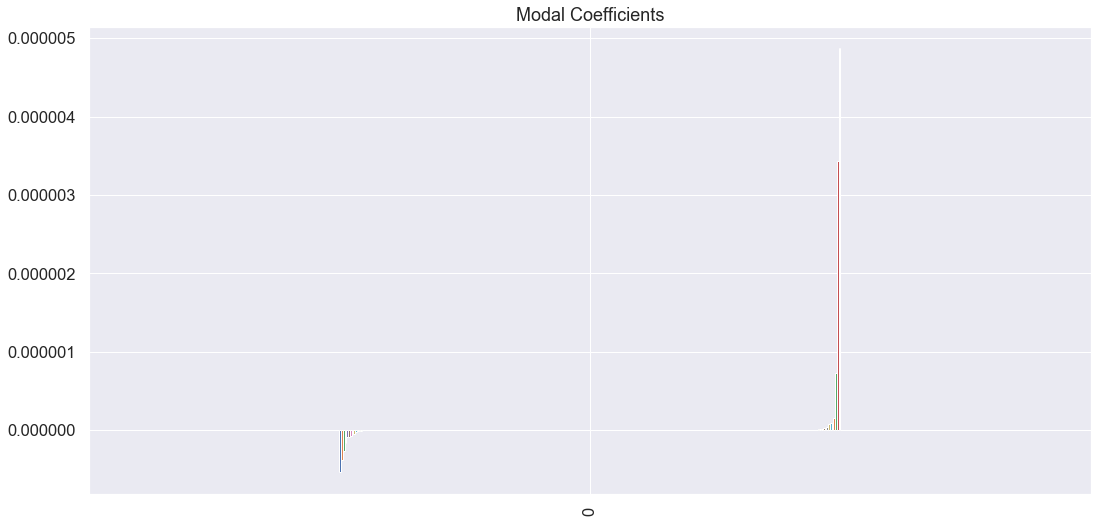

In [97]:
lasso_coef01 = pd.DataFrame(data=lasso_CV.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))



## Linear Regression Model

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y,random_state = 42, test_size=0.2)

In [99]:
# Create a linear regression object
lm_2 = LinearRegression()


# Fit the linear regression 
lm_2 = lm_2.fit(X_train, y_train)
y_train_pred = lm_2.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))

print('Training Root Mean Squared Error: ', train_rmse)



Training Root Mean Squared Error:  514.9844616359666


In [100]:
# use fitted model to predict on test data
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))

In [101]:
print('Testing Root Mean Squared Error: ' , test_rmse)
print('Training: ', int(train_rmse), 'vs. Testing: ', int(test_rmse))

Testing Root Mean Squared Error:  519.8636117866749
Training:  514 vs. Testing:  519
